In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency
import seaborn as sns


In [62]:
dataset = pd.read_csv('heart_disease_uci.csv')

<Axes: xlabel='num'>

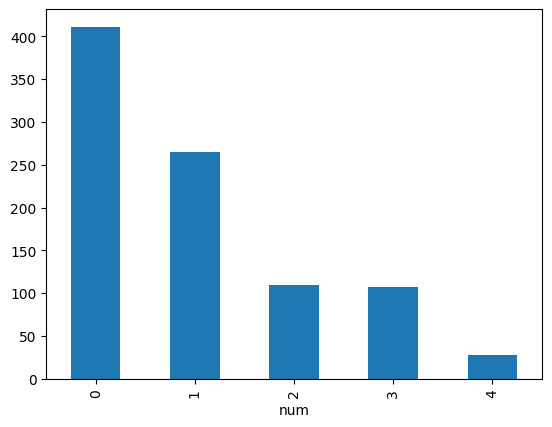

In [63]:
dataset['num'].value_counts(normalize = False).plot(kind = 'bar')

In [64]:
from sklearn.impute import SimpleImputer

def impute_with_simpleimputer(df, numerical_strategy = 'mean', categorical_strategy = 'most_frequent'):
  df_impute = df.copy()

  numerical_cols = df_impute.select_dtypes(include=[np.number]).columns
  categorical_cols = df_impute.select_dtypes(include = ['object', 'category']).columns

  if len(numerical_cols) >0:
    numeric_imputer = SimpleImputer(strategy=numerical_strategy)
    df_impute[numerical_cols]= numeric_imputer.fit_transform(df_impute[numerical_cols])

  if len(categorical_cols) >0:
    categoric_imputer = SimpleImputer(strategy=categorical_strategy)
    df_impute[categorical_cols]= categoric_imputer.fit_transform(df_impute[categorical_cols])

  return df_impute

In [65]:
df_impute = impute_with_simpleimputer(dataset)
print(df_impute.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    float64
 1   age       920 non-null    float64
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  920 non-null    float64
 6   chol      920 non-null    float64
 7   fbs       920 non-null    object 
 8   restecg   920 non-null    object 
 9   thalch    920 non-null    float64
 10  exang     920 non-null    object 
 11  oldpeak   920 non-null    float64
 12  slope     920 non-null    object 
 13  ca        920 non-null    float64
 14  thal      920 non-null    object 
 15  num       920 non-null    float64
dtypes: float64(8), object(8)
memory usage: 115.1+ KB
None


In [66]:
target = 'num'
features = df_impute.drop(columns = [target])

In [67]:
!pip install scipy

In [71]:
from scipy.stats import kruskal, normaltest, levene, f_oneway
target = 'num'
drop_rows = ['num', 'id']
features = df_impute.drop(columns=drop_rows).columns

results = []

# Loop through each feature for statistical tests only
for feature in features:
    # --- Categorical Feature vs Categorical Target ---
    if df_impute[feature].dtype == 'object' or df_impute[feature].nunique() < 10:

        # Create a contingency table
        crosstab = pd.crosstab(df_impute[feature], df_impute[target])

        # Perform Chi-Square Test
        chi2, p, dof, expected = chi2_contingency(crosstab)

        # Calculate Cramer's V (Effect Size for Chi-Square)
        n = crosstab.sum().sum()
        min_dim = min(crosstab.shape) - 1
        cramers_v = np.sqrt(chi2 / (n * min_dim))

        # Append results
        results.append({
            'Feature': feature,
            'Type': 'Categorical',
            'Test': 'Chi-Square',
            'Statistic': chi2,
            'P-Value': p,
            'Effect_Size': cramers_v,
            'Effect_Type': "Cramer's V"
        })

    # --- Numerical Feature vs Categorical Target ---
    else:
        # Get the list of groups for the target
        groups = [df_impute[df_impute[target] == level][feature] for level in df_impute[target].unique()]

        # Assumption Checks
        _, p_normality = normaltest(df_impute[feature])
        _, p_levene = levene(*groups)

        # Decide which test to use based on assumptions
        if p_normality > 0.05 and p_levene > 0.05:
            # Use ANOVA (parametric)
            stat, p_val = f_oneway(*groups)
            test_used = 'ANOVA'

            # Calculate Eta-squared
            ss_between = sum(len(g) * (g.mean() - df_impute[feature].mean())**2 for g in groups)
            ss_total = sum((x - df_impute[feature].mean())**2 for x in df_impute[feature])
            eta_squared = ss_between / ss_total
            effect_size = eta_squared
            effect_type = "Eta-squared"

        else:
            # Use Kruskal-Wallis (non-parametric)
            stat, p_val = kruskal(*groups)
            test_used = 'Kruskal-Wallis'

            # Calculate Epsilon-squared
            n_total = sum(len(g) for g in groups)
            epsilon_squared = stat / ((n_total**2 - 1) / (n_total + 1))
            effect_size = epsilon_squared
            effect_type = "Epsilon-squared"

        # Append results
        results.append({
            'Feature': feature,
            'Type': 'Numerical',
            'Test': test_used,
            'Statistic': stat,
            'P-Value': p_val,
            'Effect_Size': effect_size,
            'Effect_Type': effect_type
        })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("\n" + "="*80)
print("STATISTICAL TEST RESULTS:")
print("="*80)
print(results_df)

print("\n" + "="*80)
print("FEATURES RANKED BY EFFECT SIZE (MOST IMPORTANT FIRST):")
print("="*80)
print(results_df.sort_values('Effect_Size', ascending=False))




STATISTICAL TEST RESULTS:
     Feature         Type            Test   Statistic       P-Value  \
0        age    Numerical  Kruskal-Wallis  116.046381  3.731395e-24   
1        sex  Categorical      Chi-Square   87.729505  3.996551e-18   
2    dataset  Categorical      Chi-Square  257.001512  4.734498e-48   
3         cp  Categorical      Chi-Square  272.040658  3.404866e-51   
4   trestbps    Numerical  Kruskal-Wallis   15.863598  3.207764e-03   
5       chol    Numerical  Kruskal-Wallis   26.899501  2.083090e-05   
6        fbs  Categorical      Chi-Square   18.111664  1.173600e-03   
7    restecg  Categorical      Chi-Square   39.595312  3.810455e-06   
8     thalch    Numerical  Kruskal-Wallis  144.828043  2.610773e-30   
9      exang  Categorical      Chi-Square  174.188674  1.319344e-36   
10   oldpeak    Numerical  Kruskal-Wallis  166.787109  5.116214e-35   
11     slope  Categorical      Chi-Square   59.585715  5.619875e-10   
12        ca  Categorical      Chi-Square  152.900


Plotting top 10 features by effect size...


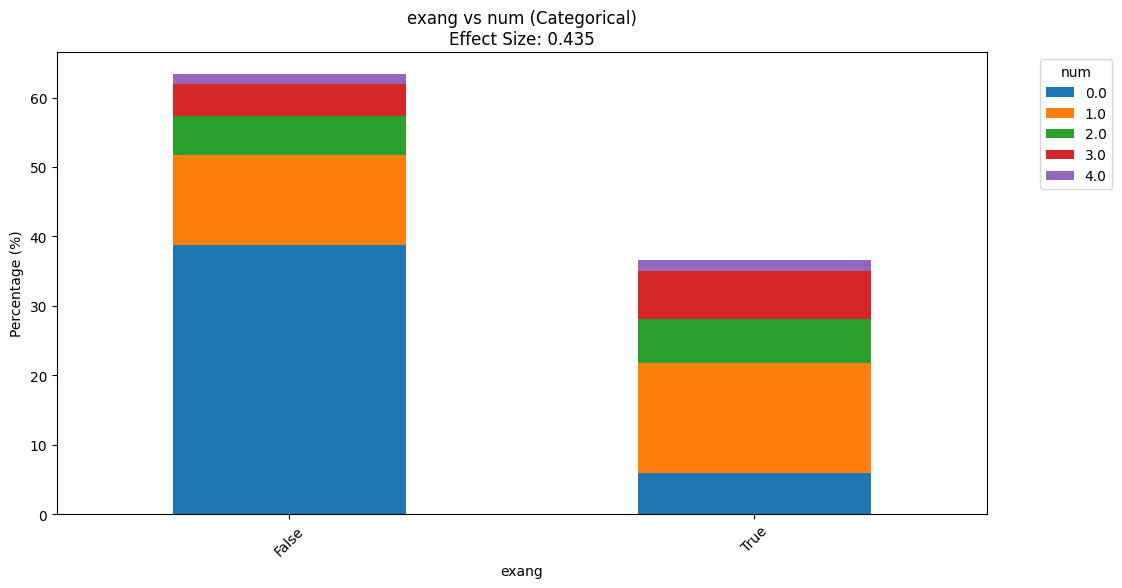

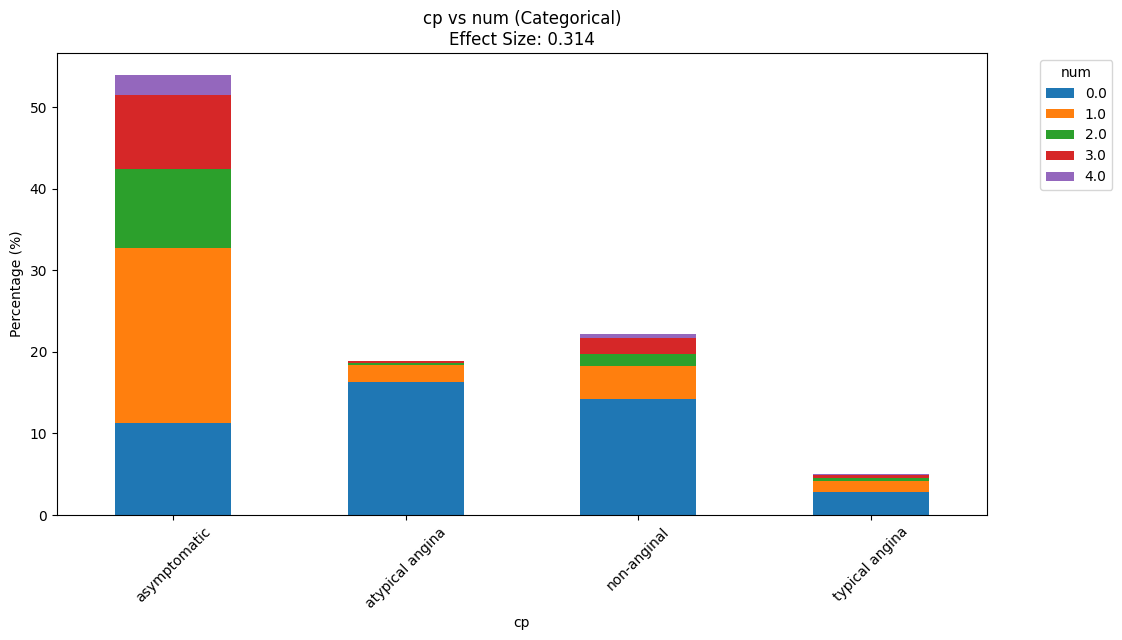

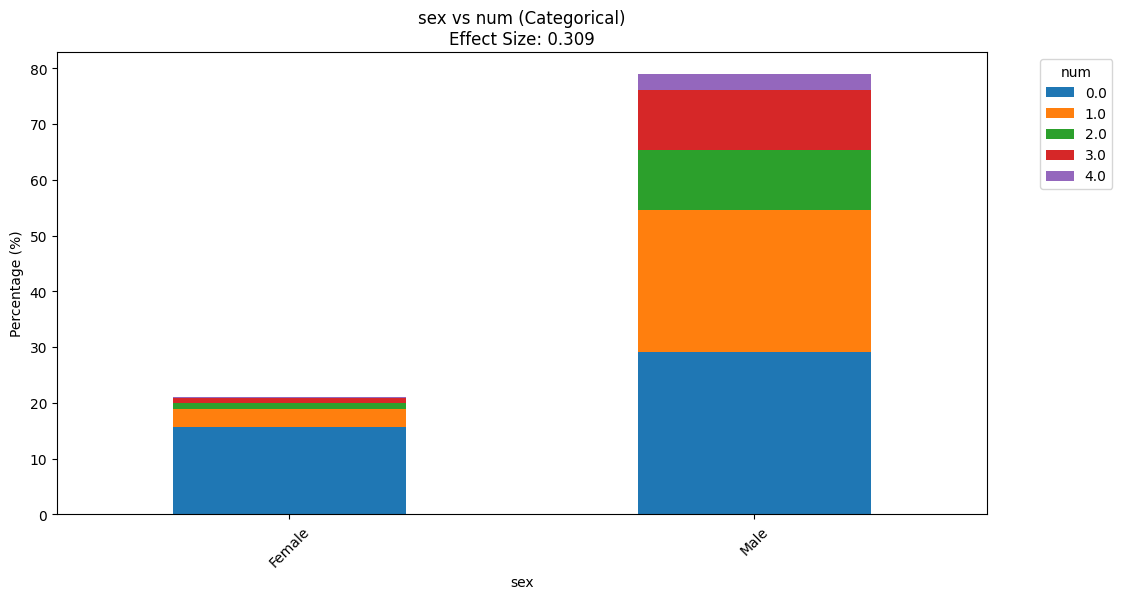

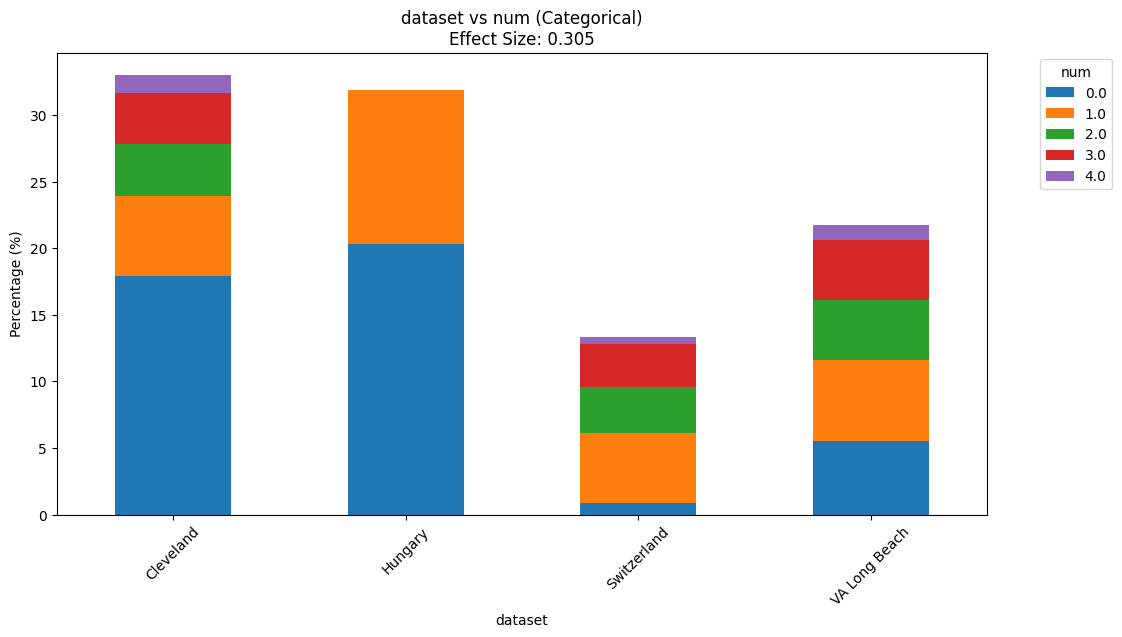

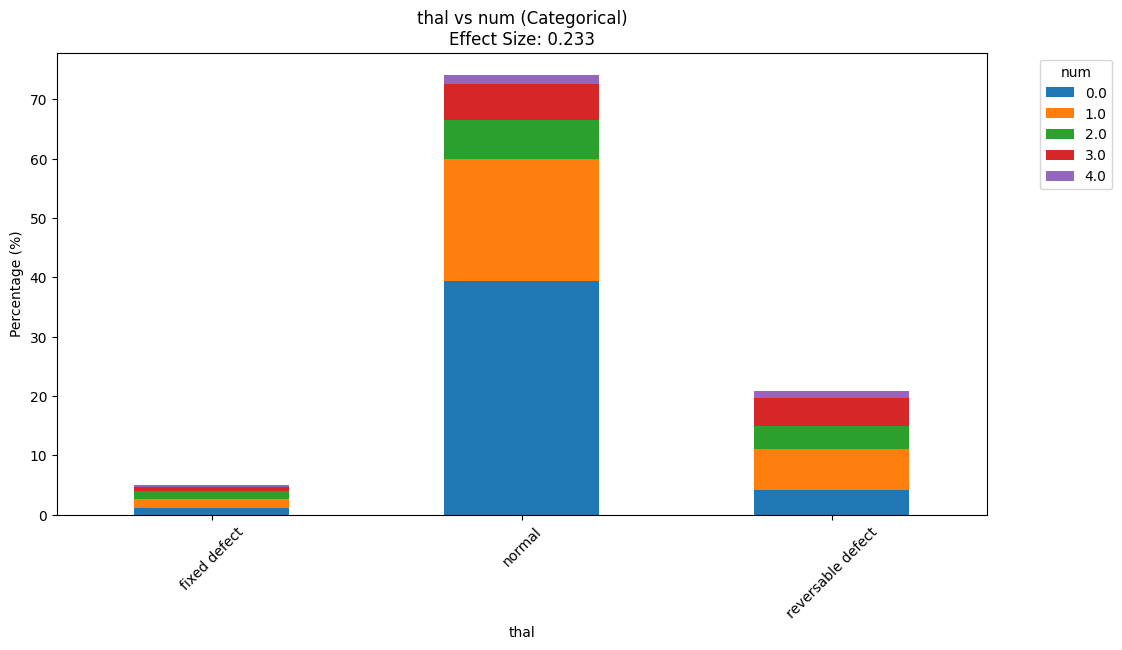

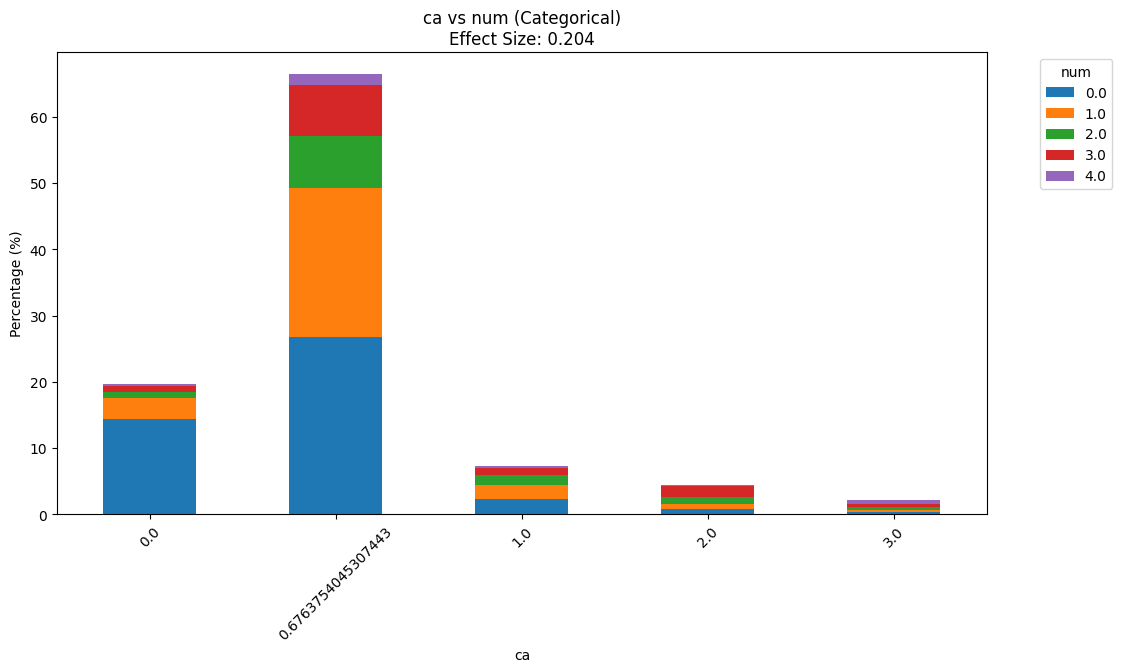

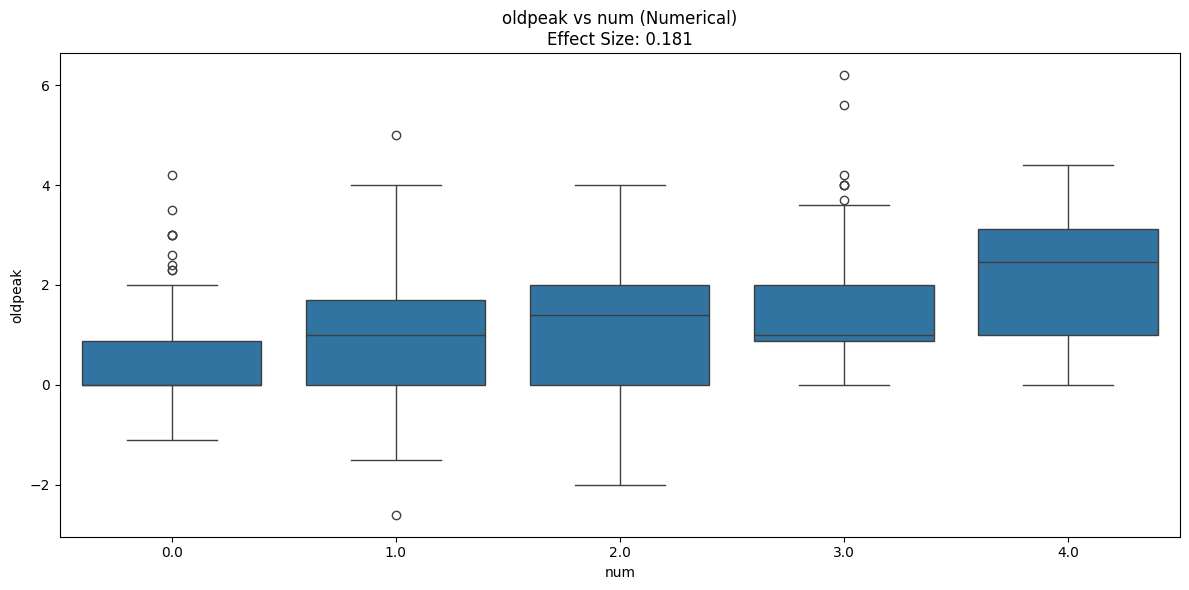

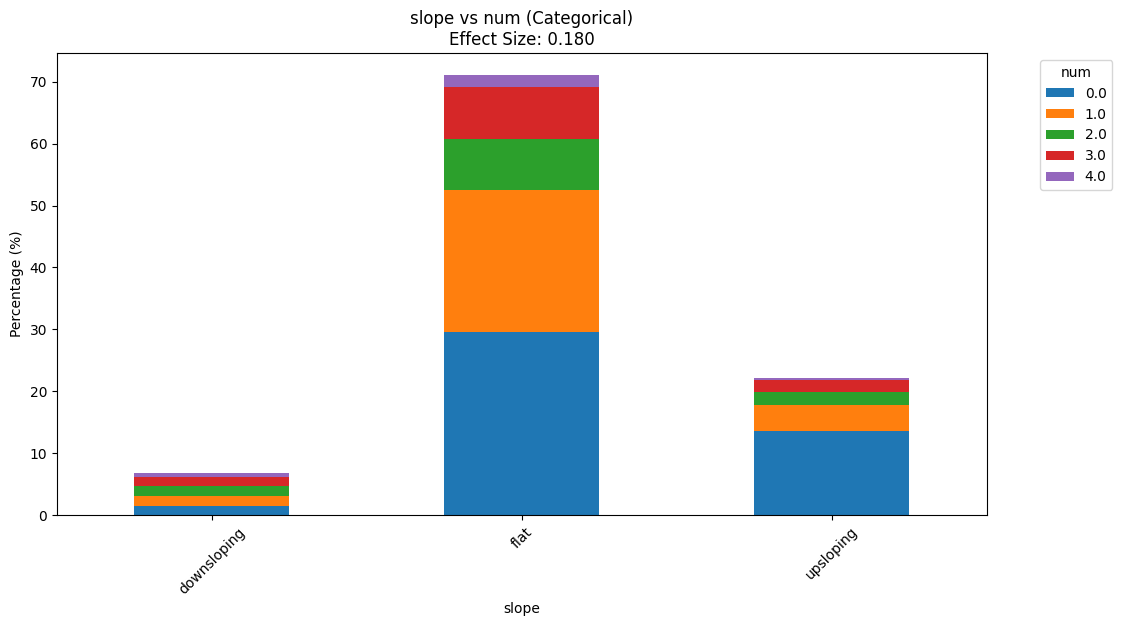

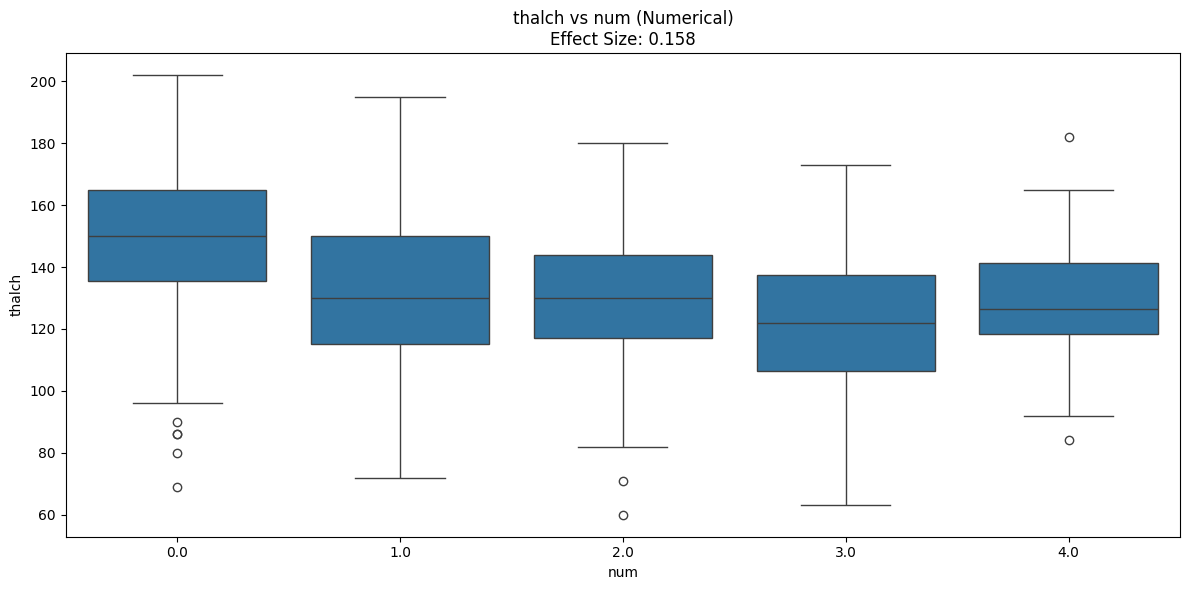

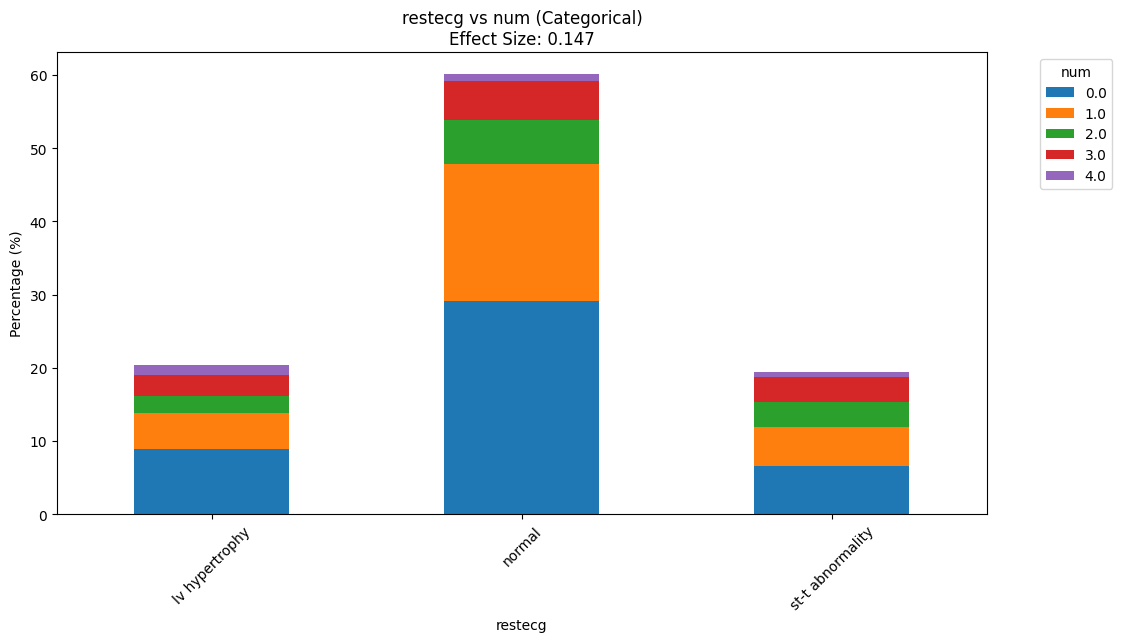

In [76]:
def plot_features(results_df, df, target, top_n = 10):
  top_features = results_df.nlargest(top_n, 'Effect_Size')['Feature'].tolist()
  print(f"\nPlotting top {top_n} features by effect size...")
  for i, feature in enumerate(top_features, 1):
    feature_type = results_df[results_df['Feature'] == feature]['Type'].values[0]
    plt.figure(figsize=(12,6))
    if feature_type == 'Categorical':
      crosstab = pd.crosstab(df_impute[feature], df_impute[target], normalize = True) * 100
      ax = crosstab.plot(kind = 'bar', stacked = True, ax = plt.gca())
      plt.title(f'{feature} vs {target} (Categorical)\nEffect Size: {results_df[results_df["Feature"] == feature]["Effect_Size"].values[0]:.3f}')
      plt.xlabel(feature)
      plt.ylabel('Percentage (%)')
      plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left')
# Rotate x-axis labels for readability
      plt.xticks(rotation=45)
    else:
      sns.boxplot(x = df_impute[target], y = df_impute[feature], ax = plt.gca())
      plt.title(f'{feature} vs {target} (Numerical)\nEffect Size: {results_df[results_df["Feature"] == feature]["Effect_Size"].values[0]:.3f}')
      plt.xlabel(target)
      plt.ylabel(feature)

      plt.tight_layout()
      plt.show()

plot_features(results_df, df_impute, target)
